In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from survae import SurVAE, DEVICE
from survae.layer import *
from survae.calibrate import *

# Standard SIR (repetition of ex04.1)

This section takes inspiration from the sample solution of exercise sheet 04: https://mampf.mathi.uni-heidelberg.de/mediaforward/medium/45620/manuscript/f4c55a7f4b503f756d1022b45bcdedd5.pdf/ex04_solutions.pdf

In [3]:
def sample_Y(n_samples:int) -> torch.Tensor:
    '''
    Generate sensible parameter values for the simulation. Uses Gaussian distribution for all three parameters.

    ### Input:
    * n_samples: Number of samples to be generated

    ### Output:
    Tensor with shape (n_sample) x 3
    '''
    # Priors of each parameter
    lam = torch.normal(0.5, 0.1, size=(n_samples,))
    mu  = torch.normal(0.25, 0.1, size=(n_samples,))
    I_0 = torch.normal(0.06, 0.05, size=(n_samples,))

    # I_0 must not be larger than 1
    I_0[I_0 > 1] = 1

    Y = torch.stack((lam, mu, I_0)).T.to(DEVICE)

    # make sure all parameters are non-negative
    Y = torch.abs(Y)

    return Y

In [5]:
def simulate_sir_simple(Y: torch.Tensor, steps_per_day: int = 10, n_days: int = 100, flatten: bool = True):
    '''
    Simulates the most basic SIR model, given parameters lambda, mu, and I_0.

    ### Inputs:
    * Y: Initial values with shape (N, 3) containing lambda, mu, and I_0 (in this order) for N simulations.
    * steps_per_day: Number of simulation steps per unit of time.
    * n_days: Number of units of time to simulate.
    * flatten: Whether to flatten the output for each simulation.

    ### Output:
    Tensor with shape (N, n_days, 2) containing dS and dR (in this order) for each simulation and unit of time.
    If 'flatten' is True, the tensor will instead have shape (N, n_days * 2)
    '''
    # extract initial values
    lam = Y[:, 0]
    mu = Y[:, 1]
    I_0 = Y[:, 2]

    h = 1 / steps_per_day      # step size
    n = len(Y)                 # number of samples, i.e. simulations
    t = steps_per_day * n_days # number of simulation steps

    C = torch.zeros((n, t+1, 2)) # contains S & R for each simulation and timestep
    C[:, 0, 0] = 1 - I_0

    for i in range(t):
        # define S, I, R
        S = C[:, i, 0]
        R = C[:, i, 1]
        I = 1 - S - R

        # compute derivatives
        dS = -lam * S * I
        dR = mu * I

        # compute one step
        C[:, i+1, 0] = S + h * dS
        C[:, i+1, 1] = R + h * dR
    
    # compute the desired output
    X = C[:, 1::steps_per_day] - C[:, :-1:steps_per_day]
    X[:, :, 0] *= -1 # convention necessitates that dS change sign

    if flatten:
        X = X.flatten(start_dim=1)

    return X

### Figure out good summary network size

In [5]:
def train_ffnn(model, X, y, batch_size, epochs, lr=1e-3):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    mse = nn.MSELoss()

    log = {
        'loss_train': [],
    }

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()

        r = torch.randperm(len(X))
        x_train = X[r][:batch_size]
        y_train = y[r][:batch_size]

        z = model(y_train)

        loss = mse(z, x_train)
        loss.backward()

        optimizer.step()
        log['loss_train'].append(loss.item())

    return log

In [82]:
Y_train = sample_Y(100_000)
X_train = simulate_sir_simple(Y_train)

In [86]:
hyp_hidden_sizes = [(16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]

fns = [FFNN(200, hidden_sizes, 3) for hidden_sizes in hyp_hidden_sizes]

In [87]:
for fn in fns:
    train_ffnn(fn, Y_train, X_train, 1000, 3000)

100%|██████████| 3000/3000 [00:45<00:00, 65.63it/s]


In [88]:
Y_val = sample_Y(1_000)
X_val = simulate_sir_simple(Y_val)

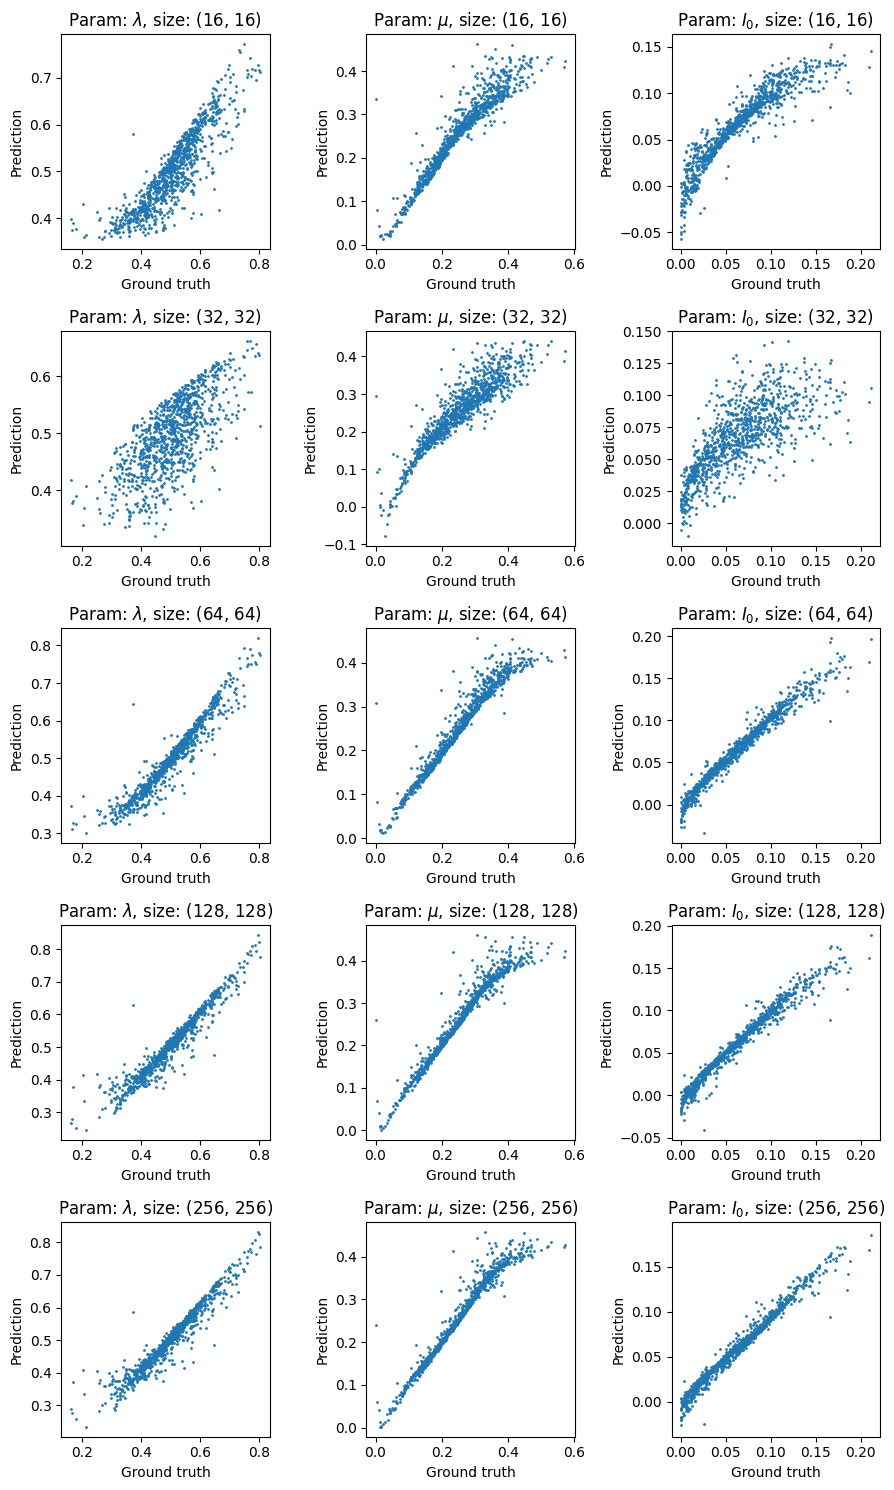

In [89]:
width = Y_val.shape[-1]
height = len(hyp_hidden_sizes)

param_names = (r"$\lambda$", r"$\mu$", r"$I_0$")

fig, ax = plt.subplots(height, width, figsize=(3*width, 3*height))

for k in range(height):
    Y_hat = fns[k](X_val)

    for i in range(width):
        _ax = ax[k][i]
        _ax.scatter(Y_val[:, i].detach().cpu().numpy(), Y_hat[:, i].detach().cpu().numpy(), s=1)

        _ax.set_title(f'Param: {param_names[i]}, size: {hyp_hidden_sizes[k]}')
        _ax.set_xlabel('Ground truth')
        _ax.set_ylabel('Prediction')

plt.axis('equal')
plt.tight_layout()
plt.show()

We choose hidden size (64, 64) for the remainder of the notebook.

### Train NF

In [6]:
def train(model:SurVAE, X, y, X_val, y_val, batch_size, epochs, lr=1e-3, gamma=0.9, validation_interval=10):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=gamma)

    log = {
        'loss_train': [],
        'loss_val': [],
        'lr': [],
    }

    # TODO the lecture notes and sample solution say the factor should be 0.5 instead of 0.25.
    # However, that value seems to result in the wrong standard deviation.
    # I have no idea what the issue is. 0.25 seems to work here.
    loss_fct = lambda _z, _ll: (0.25 * torch.sum(_z.norm(dim=1) ** 2) - _ll) / len(_z)

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()

        r = torch.randperm(len(X))
        x_train = X[r][:batch_size]
        y_train = y[r][:batch_size]

        z, ll = model(x_train, y_train, return_log_likelihood=True)

        loss = loss_fct(z, ll)
        loss.backward()

        optimizer.step()
        log['loss_train'].append(loss.item())
        scheduler.step()
        log['lr'].append(optimizer.param_groups[0]['lr'])

        if epoch%validation_interval == 0:
            z_val, ll_val = model(X_val, y_val, return_log_likelihood=True)
            loss_val = loss_fct(z_val, ll_val)

            log['loss_val'].append(loss_val.item())
    
    return log

In [52]:
sv_sir = SurVAE(
    [
        [BijectiveLayer(3, (150, 150)), OrthonormalLayer(3)]
        for _ in range(30)
    ],
    name="NF",
    condition_size=100,
    summary=FFNN(200, (200, 200), 100),
)

In [53]:
Y_train = sample_Y(100_000)
X_train = simulate_sir_simple(Y_train)

Y_val = sample_Y(500)
X_val = simulate_sir_simple(Y_val)

In [67]:
log = train(
    sv_sir,
    Y_train,
    X_train,
    Y_val,
    X_val,
    batch_size=1500,
    epochs=4000,
    lr=1e-3,
)

100%|██████████| 2000/2000 [07:09<00:00,  4.65it/s]


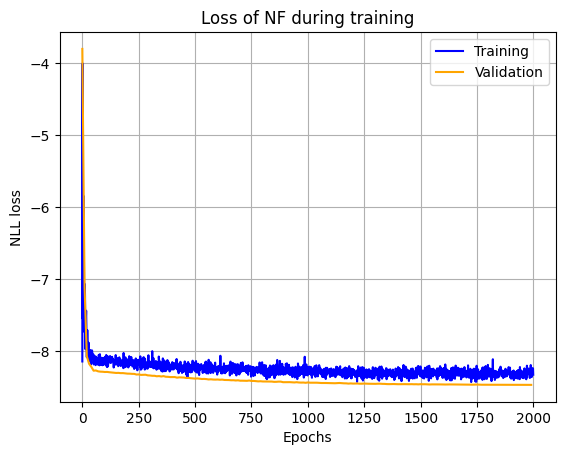

In [68]:
_y1 = log['loss_train']
_x1 = np.arange(len(_y1))

_y2 = log['loss_val']
_x2 = np.arange(len(_y2)) * 10

plt.plot(_x1, _y1, color='blue', label='Training')
plt.plot(_x2, _y2, color='orange', label='Validation')

plt.title('Loss of NF during training')
plt.xlabel('Epochs')
plt.ylabel('NLL loss')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

Introducing learning rate decay massively increased training quality and stability.

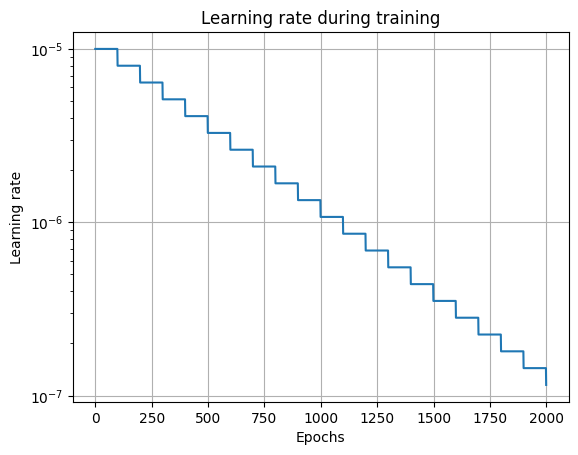

In [69]:
_y = log['lr']
_x = np.arange(len(_y))

plt.plot(_x, _y)

plt.title('Learning rate during training')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.semilogy()
plt.grid()
plt.show()

## Perform checks

### Plot code distribution

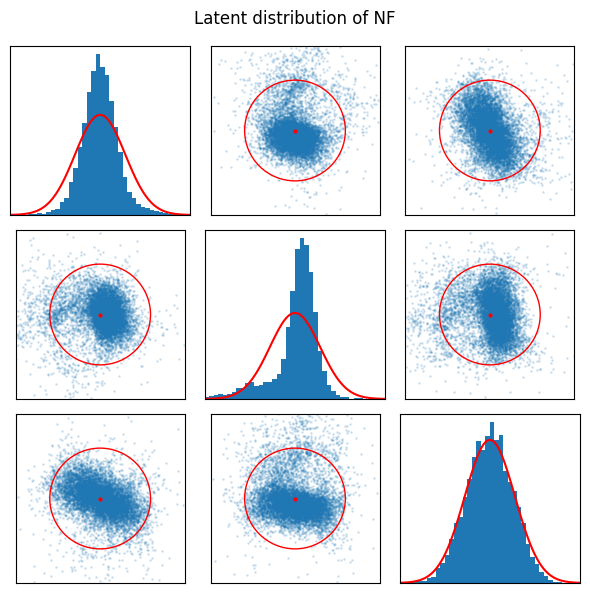

In [70]:
Y_val = sample_Y(10_000)
X_val = simulate_sir_simple(Y_val)

with torch.no_grad():
    Y_hat = sv_sir(Y_val, X_val).cpu().numpy()

plot_learned_distribution(Y_hat, 'Latent distribution of NF')

This is really bad and I don't know why.

### Plot calibration diagrams

In [71]:
Y_val = sample_Y(100)
X_val = simulate_sir_simple(Y_val)
cs = compute_calibration_values(sv_sir, Y_val, X_val, 40)

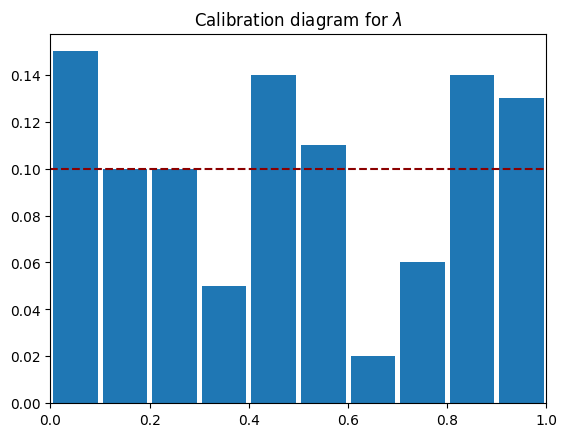

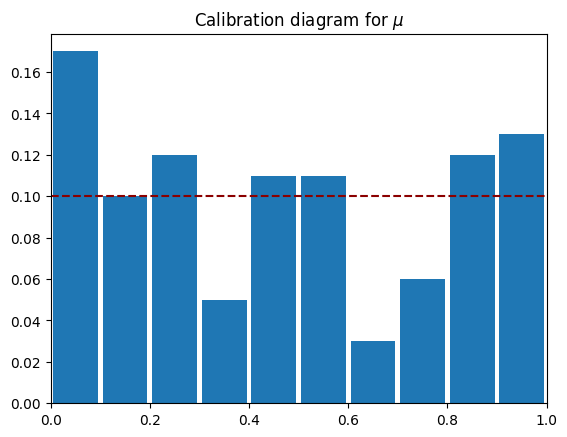

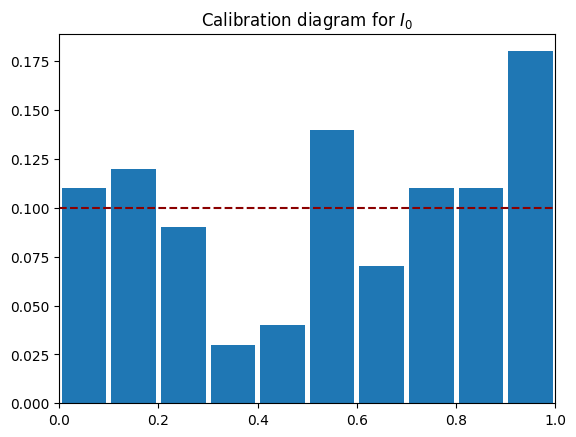

In [72]:
plot_calibration_history(cs[0], 10, r"Calibration diagram for $\lambda$")
plot_calibration_history(cs[1], 10, r"Calibration diagram for $\mu$")
plot_calibration_history(cs[2], 10, r"Calibration diagram for $I_0$")

### Resimulation

In [77]:
def resimulate(model: SurVAE, sim, Y: torch.Tensor, n_samples: int = 50):
    '''
    Perform a resimulation of parameters predicted by the model.

    ### Inputs:
    * model: Trained SBI SurVAE model.
    * sim: Simulation function.
    * Y: Tensor of shape (C, D), where C is the number of conditions and D is the number of parameters.
    * n_samples: Number of samples per condition.
    '''
    n_conditions = len(Y)
    X = sim(Y)

    X = X.repeat_interleave(n_samples, dim=0)
    Y_hat = model.sample(n_samples * n_conditions, X)

    # # make sure the sampled parameters are non-negative TODO remove
    # Y = Y.abs()

    X_resim: torch.Tensor = sim(Y_hat)
    X_resim = X_resim.reshape(n_conditions, n_samples, -1)

    return X_resim

In [84]:
def plot_resimulation(GT: torch.Tensor, X_resim: torch.Tensor, **kwargs):
    '''
    Plot data produced by "resimulate". The two functions are separate to allow for data cleanup of the resimulation output.

    ### Inputs:
    * GT: Ground-truth simulation which was resimulated. Has shape (D,).
    * X_resim: Resimulation data. Has shape (N_SAMPLES, D).
    '''
    means = X_resim.mean(dim=0).cpu().numpy()
    quantiles = X_resim.quantile(torch.tensor([0.05, 0.95]), dim=0).cpu().numpy()
    _x = np.arange(len(GT))

    plt.figure(**kwargs)
    plt.fill_between(_x, quantiles[0, :], quantiles[1, :], alpha=0.2, label='90%')
    plt.plot(_x, means, linestyle='--', alpha=0.8, label='Mean')
    plt.plot(_x, GT.cpu().numpy(), label='Ground truth')

    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()


In [96]:
# Resimulate for a handful of values
n_resims = 3
n_samples = 463
Y = sample_Y(n_resims)
X = simulate_sir_simple(Y)
X_resim = resimulate(sv_sir, simulate_sir_simple, Y, n_samples=n_samples)

# Extract dS-information from data (simulation data consists of alternating values for dS and dR)
dS = X.reshape(n_resims, 100, 2)[..., 0]
dS_resim = X_resim.reshape(n_resims, n_samples, 100, 2)[..., 0]

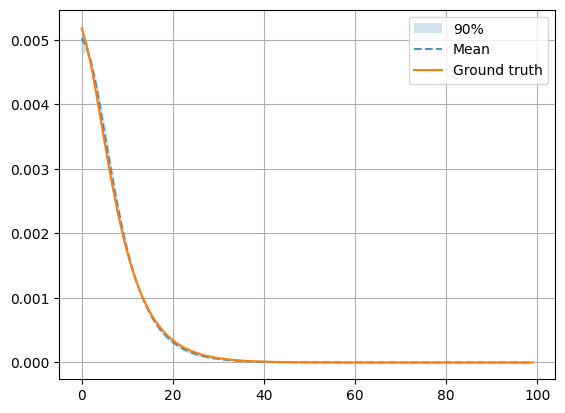

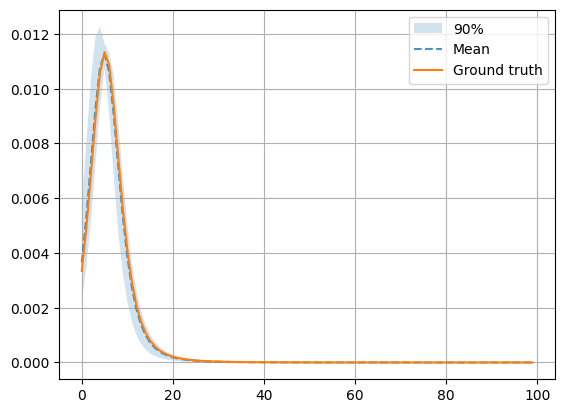

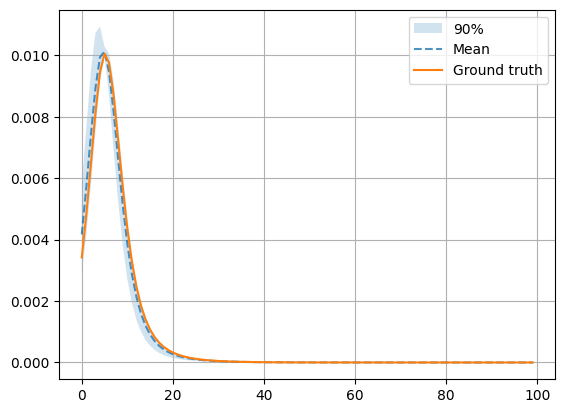

In [97]:
for _dS, _dS_resim in zip(dS, dS_resim):
    plot_resimulation(_dS, _dS_resim)

At least this looks alright.

# Parameter-degenerate SIR

Here, the SIR model has two lambda values that are summed during simulation so as to not be unambiguously recoverable.

In [98]:
def sample_Y_degen(n_samples:int) -> torch.Tensor:
    '''
    Generate sensible parameter values for the simulation. Uses Gaussian distribution for all parameters.
    In contrast to the non-degenerate case, this function generates two values for lambda.

    ### Input:
    - n_samples: Number of samples to be generated

    ### Output:
    Tensor with shape (n_sample) x 3
    '''
    # Priors of each parameter
    lam1 = torch.normal(0.2, 0.1, size=(n_samples,))
    lam2 = torch.normal(0.3, 0.1, size=(n_samples,))
    mu  = torch.normal(0.25, 0.1, size=(n_samples,))
    I_0 = torch.normal(0.06, 0.05, size=(n_samples,))

    # I_0 must not be larger than 1
    I_0[I_0 > 1] = 1

    Y = torch.stack((lam1, lam2, mu, I_0)).T.to(DEVICE)

    # make sure all parameters are non-negative
    Y = torch.abs(Y)

    return Y

In [99]:
def simulate_sir_simple_degen(Y: torch.Tensor, steps_per_day: int = 10, n_days: int = 100, flatten: bool = True):
    '''
    Simulates the most basic SIR model, given parameters lambda1, lambda2, mu, and I_0.

    ### Inputs:
    * Y: Initial values with shape (N, 4) containing lambda1, lambda2, mu, and I_0 (in this order) for N simulations.
    * steps_per_day: Number of simulation steps per unit of time.
    * n_days: Number of units of time to simulate.
    * flatten: Whether to flatten the output for each simulation.

    ### Output:
    Tensor with shape (N, n_days, 2) containing dS and dR (in this order) for each simulation and unit of time.
    If 'flatten' is True, the tensor will instead have shape (N, n_days * 2)
    '''
    # extract initial values
    lam1 = Y[:, 0]
    lam2 = Y[:, 1]
    lam = lam1 + lam2
    mu = Y[:, 2]
    I_0 = Y[:, 3]

    h = 1 / steps_per_day      # step size
    n = len(Y)                 # number of samples, i.e. simulations
    t = steps_per_day * n_days # number of simulation steps

    C = torch.zeros((n, t+1, 2)) # contains S & R for each simulation and timestep
    C[:, 0, 0] = 1 - I_0

    for i in range(t):
        # define S, I, R
        S = C[:, i, 0]
        R = C[:, i, 1]
        I = 1 - S - R

        # compute derivatives
        dS = -lam * S * I
        dR = mu * I

        # compute one step
        C[:, i+1, 0] = S + h * dS
        C[:, i+1, 1] = R + h * dR
    
    # compute the desired output
    X = C[:, 1::steps_per_day] - C[:, :-1:steps_per_day]
    X[:, :, 0] *= -1 # convention necessitates that dS change sign

    if flatten:
        X = X.flatten(start_dim=1)

    return X

### Figure out good summary network size

In [81]:
Y_train_degen = sample_Y_degen(100_000)
X_train_degen = simulate_sir_simple_degen(Y_train_degen)

In [106]:
# hyp_hidden_sizes = [(16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]
hyp_hidden_sizes = [(64, 64), (200, 200), (200, 200, 100)]

fns = [FFNN(200, hidden_sizes, 4) for hidden_sizes in hyp_hidden_sizes]

In [107]:
for fn in fns:
    train_ffnn(fn, Y_train_degen, X_train_degen, 1000, 3000)

100%|██████████| 3000/3000 [00:49<00:00, 60.37it/s]


In [110]:
Y_val_degen = sample_Y_degen(1_000)
X_val_degen = simulate_sir_simple_degen(Y_val_degen)

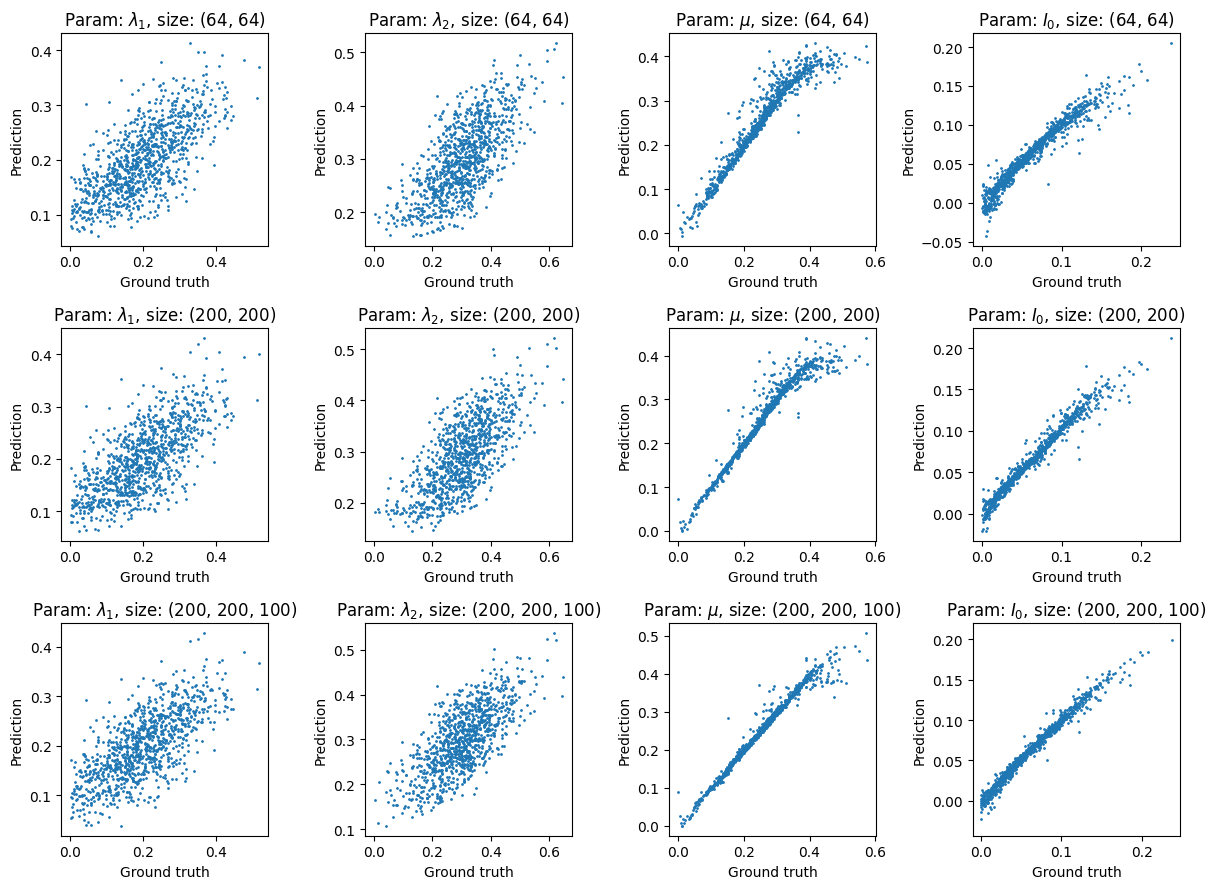

In [111]:
width = Y_val.shape[-1]
height = len(hyp_hidden_sizes)

param_names = (r"$\lambda_1$", r"$\lambda_2$", r"$\mu$", r"$I_0$")

fig, ax = plt.subplots(height, width, figsize=(3*width, 3*height))

for k in range(height):
    Y_hat = fns[k](X_val_degen)

    for i in range(width):
        _ax = ax[k][i]
        _ax.scatter(Y_val[:, i].detach().cpu().numpy(), Y_hat[:, i].detach().cpu().numpy(), s=1)

        _ax.set_title(f'Param: {param_names[i]}, size: {hyp_hidden_sizes[k]}')
        _ax.set_xlabel('Ground truth')
        _ax.set_ylabel('Prediction')

plt.axis('equal')
plt.tight_layout()
plt.show()

As expected, the lambda parameters cannot be precisely predicted.

### Train NF

In [100]:
sv_sir_degen = SurVAE(
    [
        [BijectiveLayer(4, (150, 150)), OrthonormalLayer(4)]
        for _ in range(30)
    ],
    name="NF",
    condition_size=100,
    summary=FFNN(200, (200, 200), 100),
)

In [101]:
Y_train_degen = sample_Y_degen(100_000)
X_train_degen = simulate_sir_simple_degen(Y_train_degen)

Y_val_degen = sample_Y_degen(500)
X_val_degen = simulate_sir_simple_degen(Y_val_degen)

In [102]:
log_degen = train(
    sv_sir_degen,
    Y_train_degen,
    X_train_degen,
    Y_val_degen,
    X_val_degen,
    batch_size=1500,
    epochs=3000,
    lr=1e-3,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [10:47<00:00,  4.63it/s]


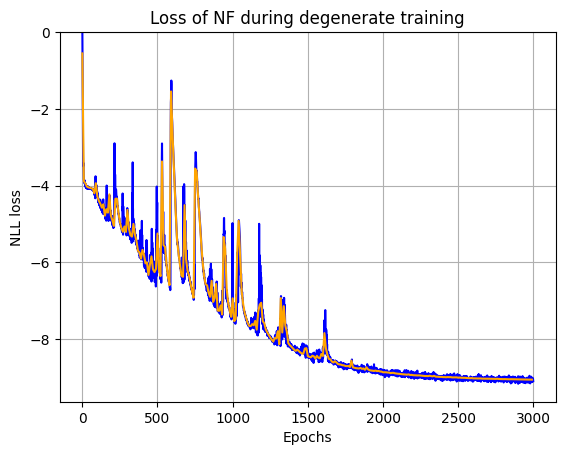

In [103]:
_y1 = log_degen['loss_train']
_x1 = np.arange(len(_y1))

_y2 = log_degen['loss_val']
_x2 = np.arange(len(_y2)) * 10

plt.plot(_x1, _y1, color='blue', label='Training')
plt.plot(_x2, _y2, color='orange', label='Validation')

plt.ylim(top=0)
plt.title('Loss of NF during degenerate training')
plt.xlabel('Epochs')
plt.ylabel('NLL loss')
plt.grid()
plt.show()

## Perform checks

### Plot code distribution

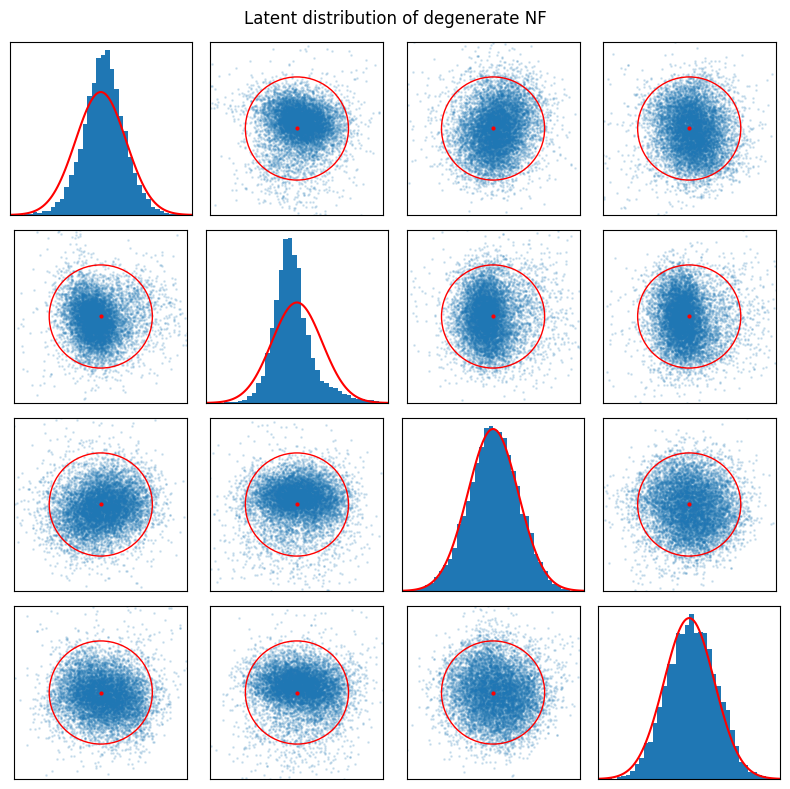

In [104]:
# check that the codes form a Gaussian bell
Y_val_degen = sample_Y_degen(10_000)
X_val_degen = simulate_sir_simple_degen(Y_val_degen)

with torch.no_grad():
    Y_hat = sv_sir_degen(Y_val_degen, X_val_degen).cpu().numpy()

plot_learned_distribution(Y_hat, 'Latent distribution of degenerate NF')

### Plot calibration diagrams

In [105]:
Y_val_degen = sample_Y_degen(100)
X_val_degen = simulate_sir_simple_degen(Y_val_degen)
cs_degen = compute_calibration_values(sv_sir_degen, Y_val_degen, X_val_degen, 40)

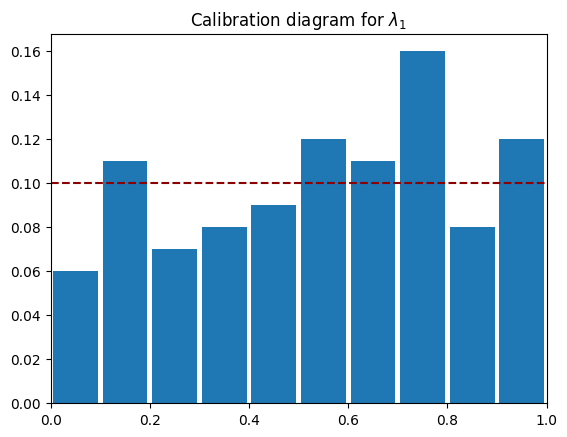

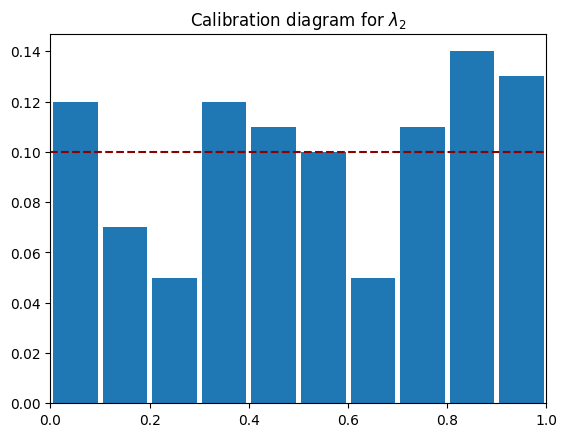

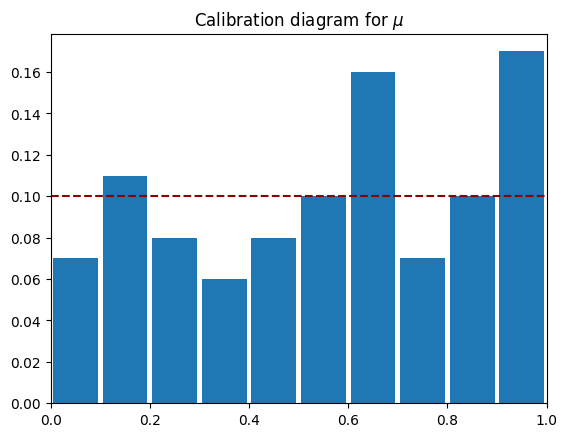

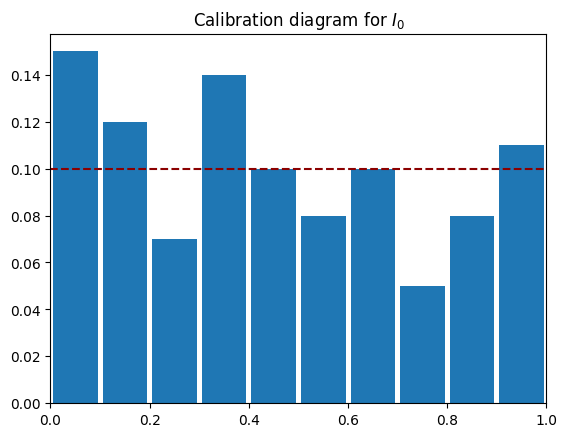

In [106]:
plot_calibration_history(cs_degen[0], 10, r"Calibration diagram for $\lambda_1$")
plot_calibration_history(cs_degen[1], 10, r"Calibration diagram for $\lambda_2$")
plot_calibration_history(cs_degen[2], 10, r"Calibration diagram for $\mu$")
plot_calibration_history(cs_degen[3], 10, r"Calibration diagram for $I_0$")

### Resimulation

In [107]:
# Resimulate for a handful of values
n_resims = 3
n_samples = 463
Y_degen = sample_Y_degen(n_resims)
X_degen = simulate_sir_simple_degen(Y_degen)
X_resim = resimulate(sv_sir_degen, simulate_sir_simple_degen, Y_degen, n_samples=n_samples)

# Extract dS-information from data (simulation data consists of alternating values for dS and dR)
dS = X_degen.reshape(n_resims, 100, 2)[..., 0]
dS_resim = X_resim.reshape(n_resims, n_samples, 100, 2)[..., 0]

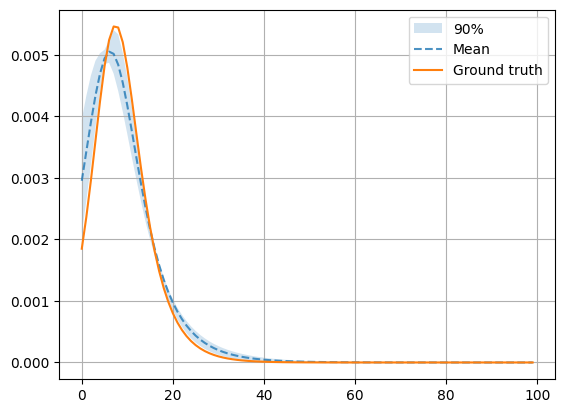

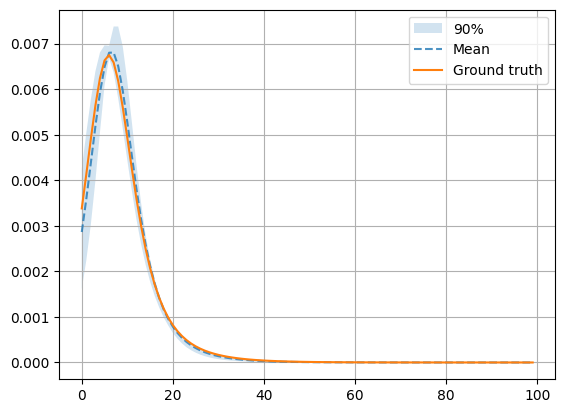

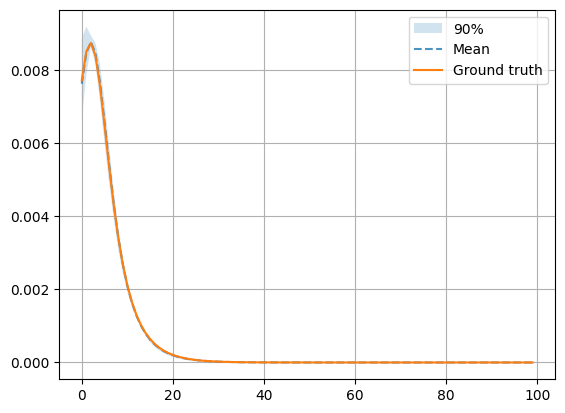

In [108]:
for _dS, _dS_resim in zip(dS, dS_resim):
    plot_resimulation(_dS, _dS_resim)

# More degenerate dataset

Since the previous dataset was handled with ease by the standard NF, we try the same with an even more degenerate dataset.

In [18]:
def sample_Y_degen2(n_samples:int) -> torch.Tensor:
    '''
    Generate sensible parameter values for the simulation. Uses Gaussian distribution for all parameters.
    In contrast to the non-degenerate case, this function generates three values for lambda.

    ### Input:
    - n_samples: Number of samples to be generated

    ### Output:
    Tensor with shape (n_sample) x 3
    '''
    # Priors of each parameter
    lam1 = torch.normal(0.2, 0.1, size=(n_samples,))
    lam2 = torch.normal(0.1, 0.1, size=(n_samples,))
    lam3 = torch.normal(0.2, 0.1, size=(n_samples,))
    mu  = torch.normal(0.25, 0.1, size=(n_samples,))
    I_0 = torch.normal(0.06, 0.05, size=(n_samples,))

    # I_0 must not be larger than 1
    I_0[I_0 > 1] = 1

    Y = torch.stack((lam1, lam2, lam3, mu, I_0)).T.to(DEVICE)

    # make sure all parameters are non-negative
    Y = torch.abs(Y)

    return Y

In [19]:
def simulate_sir_simple_degen2(Y: torch.Tensor, steps_per_day: int = 10, n_days: int = 100, flatten: bool = True):
    '''
    Simulates the most basic SIR model, given parameters lambda1, lambda2, mu, and I_0.

    ### Inputs:
    * Y: Initial values with shape (N, 5) containing lambda1, lambda2, lambda3, mu, and I_0 (in this order) for N simulations.
    * steps_per_day: Number of simulation steps per unit of time.
    * n_days: Number of units of time to simulate.
    * flatten: Whether to flatten the output for each simulation.

    ### Output:
    Tensor with shape (N, n_days, 2) containing dS and dR (in this order) for each simulation and unit of time.
    If 'flatten' is True, the tensor will instead have shape (N, n_days * 2)
    '''
    # extract initial values
    lam1 = Y[:, 0]
    lam2 = Y[:, 1]
    lam3 = Y[:, 2]
    lam = lam1 + lam2 + lam3
    mu = Y[:, 3]
    I_0 = Y[:, 4]

    h = 1 / steps_per_day      # step size
    n = len(Y)                 # number of samples, i.e. simulations
    t = steps_per_day * n_days # number of simulation steps

    C = torch.zeros((n, t+1, 2)) # contains S & R for each simulation and timestep
    C[:, 0, 0] = 1 - I_0

    for i in range(t):
        # define S, I, R
        S = C[:, i, 0]
        R = C[:, i, 1]
        I = 1 - S - R

        # compute derivatives
        dS = -lam * S * I
        dR = mu * I

        # compute one step
        C[:, i+1, 0] = S + h * dS
        C[:, i+1, 1] = R + h * dR
    
    # compute the desired output
    X = C[:, 1::steps_per_day] - C[:, :-1:steps_per_day]
    X[:, :, 0] *= -1 # convention necessitates that dS change sign

    if flatten:
        X = X.flatten(start_dim=1)

    return X

### Figure out good summary network size

In [20]:
Y_train_degen2 = sample_Y_degen2(100_000)
X_train_degen2 = simulate_sir_simple_degen2(Y_train_degen2)

In [25]:
# hyp_hidden_sizes = [(16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]
hyp_hidden_sizes = [(64, 64), (200, 200), (200, 200, 100)]

fns = [FFNN(200, hidden_sizes, 5) for hidden_sizes in hyp_hidden_sizes]

In [26]:
for fn in fns:
    train_ffnn(fn, Y_train_degen2, X_train_degen2, 1000, 3000)

100%|██████████| 3000/3000 [01:18<00:00, 38.32it/s]


In [27]:
Y_val_degen2 = sample_Y_degen2(1_000)
X_val_degen2 = simulate_sir_simple_degen2(Y_val_degen2)

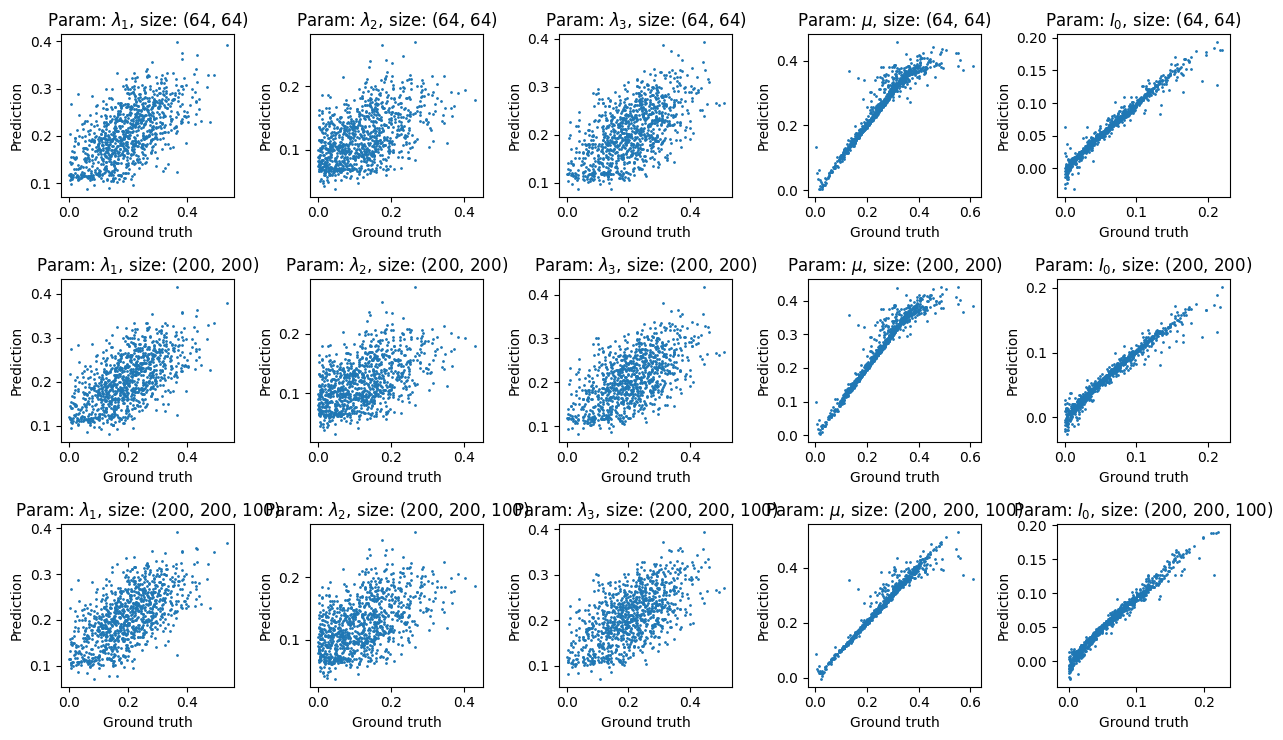

In [29]:
width = Y_val_degen2.shape[-1]
height = len(hyp_hidden_sizes)

param_names = (r"$\lambda_1$", r"$\lambda_2$", r"$\lambda_3$", r"$\mu$", r"$I_0$")

fig, ax = plt.subplots(height, width, figsize=(2.5*width, 2.5*height))

for k in range(height):
    Y_hat = fns[k](X_val_degen2)

    for i in range(width):
        _ax = ax[k][i]
        _ax.scatter(Y_val_degen2[:, i].detach().cpu().numpy(), Y_hat[:, i].detach().cpu().numpy(), s=1)

        _ax.set_title(f'Param: {param_names[i]}, size: {hyp_hidden_sizes[k]}')
        _ax.set_xlabel('Ground truth')
        _ax.set_ylabel('Prediction')

plt.axis('equal')
plt.tight_layout()
plt.show()

### Train NF

In [ ]:
sv_sir_degen2 = SurVAE(
    [
        [BijectiveLayer(4, (150, 150)), OrthonormalLayer(4)]
        for _ in range(30)
    ],
    name="NF",
    condition_size=100,
    summary=FFNN(200, (200, 200), 100),
)

In [ ]:
Y_train_degen2 = sample_Y_degen2(100_000)
X_train_degen2 = simulate_sir_simple_degen2(Y_train_degen2)

Y_val_degen2 = sample_Y_degen2(500)
X_val_degen2 = simulate_sir_simple_degen2(Y_val_degen2)

In [ ]:
log_degen2 = train(
    sv_sir_degen2,
    Y_train_degen2,
    X_train_degen2,
    Y_val_degen2,
    X_val_degen2,
    batch_size=1500,
    epochs=3000,
)

100%|██████████| 3000/3000 [11:08<00:00,  4.49it/s]


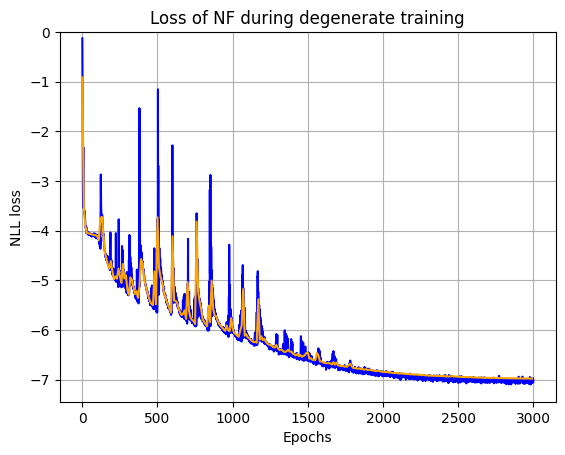

In [ ]:
_y1 = log_degen2['loss_train']
_x1 = np.arange(len(_y1))

_y2 = log_degen2['loss_val']
_x2 = np.arange(len(_y2)) * 10

plt.plot(_x1, _y1, color='blue', label='Training')
plt.plot(_x2, _y2, color='orange', label='Validation')

plt.ylim(top=0)
plt.title('Loss of NF during degenerate training')
plt.xlabel('Epochs')
plt.ylabel('NLL loss')
plt.grid()
plt.show()